In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from data.data_utils import hindi_characters_pattern
import unicodedata
import re
import numpy as np
import os
import io
import time

c:\Users\rishi\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.debugging.set_log_device_placement(False)

In [3]:
# import pandas as pd
# df = pd.read_parquet('./data/translation/eng-hi.parquet')
# df.to_csv('out.txt', index=False, sep='\t')   


In [4]:
# def extract_values(row):
#     return pd.Series([row['translation']['en'], row['translation']['hi']])

# # Apply the function to each row to create two new columns
# df[['en', 'hi']] = df.apply(extract_values, axis=1)

# # Drop the original column
# df.drop('original_column', axis=1, inplace=True)

In [5]:
# # Open the file for writing
# with open('en-hi.txt', 'w', encoding='utf-8') as file:
#     # Define the extract_values function
#     def extract_values(row):
#         en_value = row['translation']['en']
#         hi_value = row['translation']['hi']
#         # Write the values to the file separated by a tab (\t) and each row separated by a newline (\n)
#         file.write(f"{en_value}\t{hi_value}\n")
    
#     # Apply the function to each row
#     df.apply(extract_values, axis=1)

### Example of preprocessing Hindi text

In [6]:
def preprocess_hindi_text(w):
    # eg: "वह लड़का है." => "वह लड़का है ."
    # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",", "।", Hindi characters)
    w = re.sub(r"[^?.!,"+hindi_characters_pattern+"]", " ", w)        # leaving english terms also, if needed (Ideally should not be given)
    w = re.sub(r"([?.!,।])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()
    return w

# Example usage:
hindi_text = "११ राम!     बहुत अच्छा है। तीसरी योजना में लगभग सभी अतिरिक़्त क्षमता सार्वजनिक क्षेत्र को देते हुए इस्पात पिंडों का लक्ष्य 102 लाख टन पर निश्चितZ किया गया "
processed_hindi_text = preprocess_hindi_text(hindi_text)
print(processed_hindi_text)


११ राम ! बहुत अच्छा है । तीसरी योजना में लगभग सभी अतिरिक़्त क्षमता सार्वजनिक क्षेत्र को देते हुए इस्पात पिंडों का लक्ष्य लाख टन पर निश्चित किया गया


# Simplifying our dataset

DataSet has varied lengths of sentences

In [7]:
def preprocess_sentence_hindi(w):
    # Create a space between a word and the punctuation following it
    # eg: "वह लड़का है." => "वह लड़का है ."
    # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",", "।", Hindi characters)
    # Reference: https://stackoverflow.com/questions/76658990/regex-expression-to-validate-only-hindi-devnagri-letters-in-python
    w = re.sub(r"[^?.!,"+hindi_characters_pattern+"]", " ", w)        # discarded english terms also, if needed (Ideally should not be given)
    w = re.sub(r"([?.!,।])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()

    # Add a start and an end token to the sentence
    # so that the model knows when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence_english(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def get_dataset(path):
    # path : path to en-hi.txt file
    # num_examples : Limit the total number of training example for faster training (set num_examples = len(lines) to use full data)
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    # lines contains each of the lines as it is in .txt ... like 0->'Go.\tVe.', 1->'Go.\tVete.'...
    word_pairs = [[preprocess_sentence_english(l.split('\t')[0]),preprocess_sentence_hindi(l.split('\t')[1])]  for l in lines[:]]
    # word_pairs = [['<start> go . <end>', '<start> ve . <end>'],['<start> go . <end>', '<start> vete . <end>'],...]
    # del lines # releasing memory?
    return zip(*word_pairs)

In [8]:
path = "data/translation/en-hi.txt"
inp_lang, targ_lang  = get_dataset(path)

## For input sentences

In [9]:
intput_word_sentences = [list(sentence.split()) for sentence in inp_lang]

Run the following commented code to see the inputs of some lengths

In [10]:
# max_len = 0
# for i in range(len(intput_word_sentences)):
#     if max_len<len(intput_word_sentences[i]):
#         print("length -> ",len(intput_word_sentences[i])," Example : ",i,") ",inp_lang[i])
#         print(i)
#         max_len = len(intput_word_sentences[i])

In [11]:
# Calculate the lengths of all sentences
words_per_sentence = [len(sentence) for sentence in intput_word_sentences]


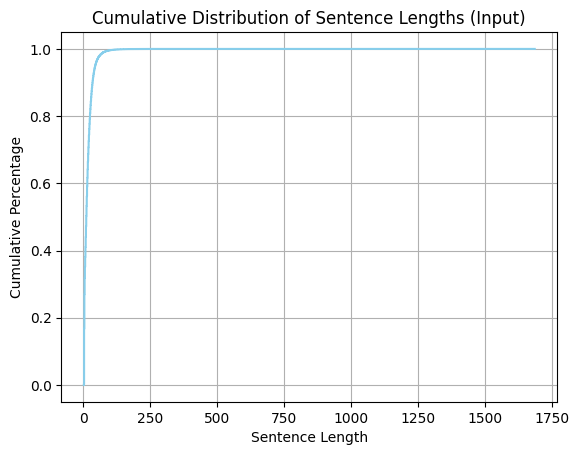

In [12]:
input_sorted_lengths = np.sort(words_per_sentence)
cumulative_percentage = np.arange(1, len(input_sorted_lengths) + 1) / len(input_sorted_lengths)

plt.step(input_sorted_lengths, cumulative_percentage, color='skyblue', where='mid')
plt.xlabel('Sentence Length')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Sentence Lengths (Input)')
plt.grid(True)
plt.show()


As can be seen from above, some high length sentences are present in very less frequency

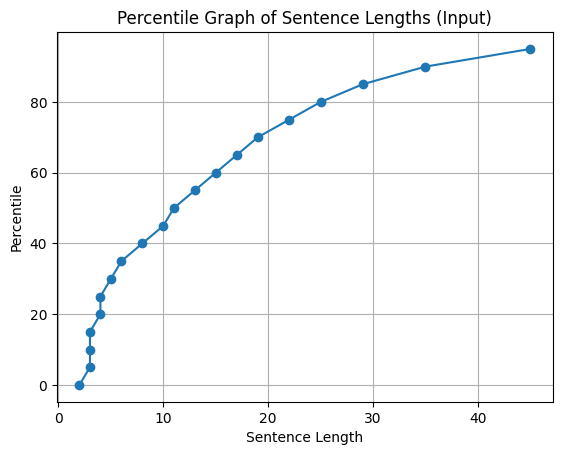

In [13]:

percentiles = np.arange(0, 100, 5)
percentile_values = np.percentile(words_per_sentence, percentiles)

plt.plot(percentile_values,percentiles, marker='o')
plt.ylabel('Percentile')
plt.xlabel('Sentence Length')
plt.title('Percentile Graph of Sentence Lengths (Input)')
plt.grid(True)
plt.show()


## For Target Sentences

In [14]:
target_word_sentences = [list(sentence.split()) for sentence in targ_lang]

Run the following commented code to see the targets of some lengths

In [15]:
# max_len = 0
# for i in range(len(target_word_sentences)):
#     if max_len<len(target_word_sentences[i]):
#         print("length -> ",len(target_word_sentences[i])," Example : ",i,") ",targ_lang[i])
#         print(i)
#         max_len = len(target_word_sentences[i])

In [16]:
# Calculate the lengths of all sentences
words_per_sentence = [len(sentence) for sentence in target_word_sentences]


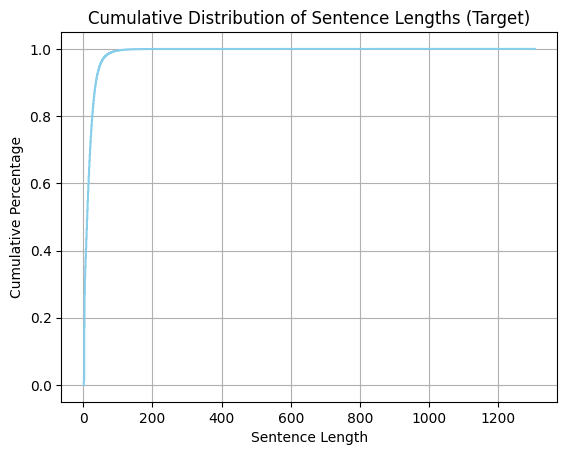

In [17]:
target_sorted_lengths = np.sort(words_per_sentence)
cumulative_percentage = np.arange(1, len(target_sorted_lengths) + 1) / len(target_sorted_lengths)

plt.step(target_sorted_lengths, cumulative_percentage, color='skyblue', where='mid')
plt.xlabel('Sentence Length')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Sentence Lengths (Target)')
plt.grid(True)
plt.show()


As can be seen from above, 

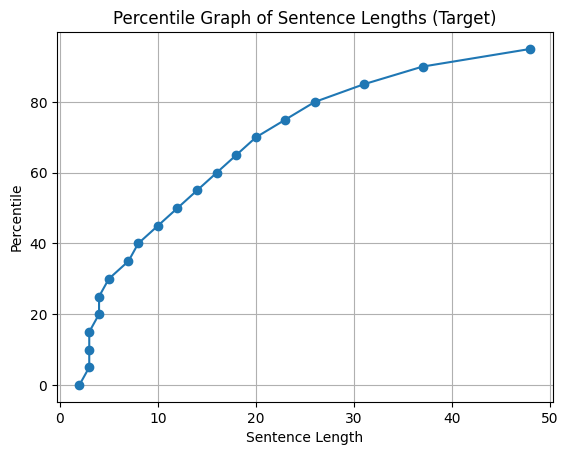

In [18]:
percentiles = np.arange(0, 100, 5)
percentile_values = np.percentile(words_per_sentence, percentiles)

plt.plot(percentile_values,percentiles, marker='o')
plt.ylabel('Percentile')
plt.xlabel('Sentence Length')
plt.title('Percentile Graph of Sentence Lengths (Target)')
plt.grid(True)
plt.show()


### Lets calculate a threshold of length that should be allowed in our dataset

In [19]:
# on the basis of input
input_sorted_lengths
curr = 0
cummulativeDict = {}
for i in range(len(input_sorted_lengths)):
    if input_sorted_lengths[i]!=curr or i == len(input_sorted_lengths)-1:
        curr = input_sorted_lengths[i]
        cummulativeDict[input_sorted_lengths[i]] = (i+1)/len(input_sorted_lengths)

In [20]:
cummulativeDict

{2: 6.027425993756792e-07,
 3: 0.0022199009935006267,
 4: 0.16759438798420573,
 5: 0.26962786069171946,
 6: 0.31830896947289555,
 7: 0.35108490654174623,
 8: 0.38061386922776014,
 9: 0.41027181883004044,
 10: 0.4408905401357256,
 11: 0.4716484949818665,
 12: 0.5028313833605672,
 13: 0.5330016641723169,
 14: 0.5618489249784369,
 15: 0.5903315265119347,
 16: 0.6166008572205248,
 17: 0.6417382373274876,
 18: 0.665150568115037,
 19: 0.6867510546488632,
 20: 0.7069013424885916,
 21: 0.7260402282465676,
 22: 0.7440025604505621,
 23: 0.7612114644053372,
 24: 0.7775192681740456,
 25: 0.7929609308274511,
 26: 0.8073809447749148,
 27: 0.8206852821709342,
 28: 0.833032464319145,
 29: 0.8446858897354743,
 30: 0.855656407786711,
 31: 0.8657053324035024,
 32: 0.8751051032407662,
 33: 0.8839425152328123,
 34: 0.8920934034041696,
 35: 0.8995939323108006,
 36: 0.9067189525780205,
 37: 0.9132430384736628,
 38: 0.9192005463258921,
 39: 0.9247783263405146,
 40: 0.9299347892781735,
 41: 0.934662099485077,


##### If I Choose length as 36, we will be able to utilize 90.67% of full data as our dataset 

In [21]:
del cummulativeDict
del curr
del input_sorted_lengths
del target_sorted_lengths
del words_per_sentence
del cumulative_percentage
del percentile_values
del percentiles
del inp_lang
del targ_lang
del path
del intput_word_sentences
del target_word_sentences

In [22]:
# disabling GPU 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"            # Without this, fragmentation was the problem (small holes left in poorly allocated GPU memory bar) resulting into OOM -> Async makes efficient

In [4]:
tf.config.list_physical_devices('GPU')              # Checking for the availability

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
class NMTDataset:
    def __init__(self, problem_type='eng-hindi',threshold=None):
        self.problem_type = problem_type
        self.inp_lang_tokenizer = None
        self.targ_lang_tokenizer = None
        self.threshold = threshold

    def unicode_to_ascii(self, s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    ## Step 1 and Step 2 
    def preprocess_sentence_hindi(self, w):
        # Create a space between a word and the punctuation following it
        # eg: "वह लड़का है." => "वह लड़का है ."
        # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",", "।", Hindi characters)
        # Reference: https://stackoverflow.com/questions/76658990/regex-expression-to-validate-only-hindi-devnagri-letters-in-python
        w = re.sub(r"[^?.!,"+hindi_characters_pattern+"]", " ", w)        # discarded english terms also, if needed (Ideally should not be given)
        w = re.sub(r"([?.!,।])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        w = w.strip()

        # Add a start and an end token to the sentence
        # so that the model knows when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w
    def preprocess_sentence_english(self, w):
        w = self.unicode_to_ascii(w.lower().strip())

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()

        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w
    
    def create_dataset(self, path, num_examples):
        # path : path to en-hi.txt file
        # num_examples : Limit the total number of training example for faster training (set num_examples = len(lines) to use full data)
        lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
        # lines contains each of the lines as it is in .txt ... like 0->'Go.\tVe.', 1->'Go.\tVete.'...
        word_pairs = []
        for l in lines[:num_examples]:
            splited = l.split('\t')
            hindi = self.preprocess_sentence_hindi(splited[1])
            english = self.preprocess_sentence_english(splited[0])
            if (not self.threshold) or (len(hindi.split(' '))<=self.threshold+2  and len(english.split(' '))<=self.threshold+2 + 10):       # this extra 10 is some extra space for input
                word_pairs.append([english, hindi])
        # word_pairs = [['<start> go . <end>', '<start> ve . <end>'],['<start> go . <end>', '<start> vete . <end>'],...]
        return zip(*word_pairs)

    # Step 3 and Step 4
    def tokenize(self, lang):
        # lang = list of sentences in a language
        
        print(len(lang), "example sentence: {}".format(lang[-1]))
        print(len(lang), "example sentence: {}".format(lang[4]))
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
        lang_tokenizer.fit_on_texts(lang)

        ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
        ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
        tensor = lang_tokenizer.texts_to_sequences(lang) 

        ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
        ## and pads the sequences to match the longest sequences in the given input
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, lang_tokenizer

    def load_dataset(self, path, num_examples=None):
        # creating cleaned input, output pairs
        # targ_lang, inp_lang = self.create_dataset(path, num_examples)             # changing the target and input if necessary
        inp_lang, targ_lang  = self.create_dataset(path, num_examples)
        # targ_lang = ('<start> go . <end>','<start> go . <end>',...)
        # inp_lang = ('<start> ve . <end>','<start> vete . <end>',...)
        input_tensor, inp_lang_tokenizer = self.tokenize(inp_lang)
        target_tensor, targ_lang_tokenizer = self.tokenize(targ_lang)
        # target_tensor = [array([ 2, 37,  4,  3,  0,  0,  0,  0,  0,  0,  0]),array([ 2, 37,  4,  3,  0,  0,  0,  0,  0,  0,  0]),...]
        # input_tensor = [array([ 2, 136,  4,  3,  0,  0,  0,  0,  0,  0,  0]),array([ 2, 294,  4,  3,  0,  0,  0,  0,  0,  0,  0]),...]
        return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

    def call(self, num_examples, BUFFER_SIZE, BATCH_SIZE):
        file_path = "data/translation/en-hi.txt"
        input_tensor, target_tensor, self.inp_lang_tokenizer, self.targ_lang_tokenizer = self.load_dataset(file_path, num_examples)
        # target_tensor = [array([ 2, 37,  4,  3,  0,  0,  0,  0,  0,  0,  0]),array([ 2, 37,  4,  3,  0,  0,  0,  0,  0,  0,  0]),...]
        # input_tensor = [array([ 2, 136,  4,  3,  0,  0,  0,  0,  0,  0,  0]),array([ 2, 294,  4,  3,  0,  0,  0,  0,  0,  0,  0]),...]
        input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

        train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)) # -> contains list of 64 trainingXY tensors -> each batch's each tensor is pair of tensors -> both containing tokenized words
        train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

        val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
        val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

        return train_dataset, val_dataset, self.inp_lang_tokenizer, self.targ_lang_tokenizer

In [6]:
BUFFER_SIZE = 61000                     # Buffer size > number of samples
BATCH_SIZE = 64
# Let's limit the #training examples for faster training
num_examples = 1659084//4                    # 1659084 <- total data size (25% taken) -> my system only works with 2.5% (8 GB RAM)
profiling_log_dir = "./profile_logs"
dataset_creator = NMTDataset('eng-hindi',threshold = 36)
train_dataset, val_dataset, inp_lang, targ_lang = dataset_creator.call(num_examples, BUFFER_SIZE, BATCH_SIZE)

356948 example sentence: <start> so on that day their pleas shall be of no avail , nor will they be allowed to make amends . <end>
356948 example sentence: <start> a list of plugins that are disabled by default <end>
356948 example sentence: <start> तो उस दिन सरकश लोगों को न उनकी उज्र माअज़ेरत कुछ काम आएगी और न उनकी सुनवाई होगी <end>
356948 example sentence: <start> उन प्लग इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है <end>


In [7]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch, example_target_batch                               # Note: two extra space in input and output is due to <start> & <end>

(<tf.Tensor: shape=(64, 48), dtype=int32, numpy=
 array([[    2, 28766,     3, ...,     0,     0,     0],
        [    2,     5,   307, ...,     0,     0,     0],
        [    2,  2852,  1760, ...,     0,     0,     0],
        ...,
        [    2,    32,  2476, ...,     0,     0,     0],
        [    2,    28,    19, ...,     0,     0,     0],
        [    2,  1768,     3, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(64, 38), dtype=int32, numpy=
 array([[    2, 26202,     7, ...,     0,     0,     0],
        [    2,   189,    41, ...,     0,     0,     0],
        [    2, 12434,  1251, ...,     0,     0,     0],
        ...,
        [    2,   531,  5512, ...,     0,     0,     0],
        [    2,    33,    45, ...,     0,     0,     0],
        [    2, 14332,     3, ...,     0,     0,     0]])>)

In [8]:
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
max_length_input = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]

embedding_dim = 256
units = 1024
steps_per_epoch = num_examples//BATCH_SIZE


In [9]:
print("max_length_english, max_length_hindi, vocab_size_english, vocab_size_hindi")
max_length_input, max_length_output, vocab_inp_size, vocab_tar_size

max_length_english, max_length_hindi, vocab_size_english, vocab_size_hindi


(48, 38, 34365, 31733)

In [10]:
##### ENCODER

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)                  # input embedding -> vocab_size * embedding_dim -> Network's lookup table (https://www.tensorflow.org/text/guide/word_embeddings) -> also knows the relationship between words

    ##-------- LSTM layer in Encoder ------- ##
    self.lstm_layer = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    


  def call(self, x, hidden):
    x = self.embedding(x)
    # print("Encoding: ",x)
    output, h, c = self.lstm_layer(x, initial_state = hidden)
    return output, h, c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))] 

In [11]:
# initialize Encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [12]:
# Function to estimate memory usage of a tensor
def estimate_memory(tensor):
    num_elements = tf.size(tensor)
    data_type_size = tensor.dtype.size
    memory_usage = num_elements * data_type_size
    return memory_usage

In [13]:
## Test Encoder Stack
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)

In [14]:

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))     # this output shape has sequence length too (in middle, 48) -> since return_sequence = True
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))                         # Notice the symmetry breaking problem
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))                         # Notice the symmetry breaking problem

output_size = estimate_memory(sample_output)
h_size = estimate_memory(sample_h)
c_size = estimate_memory(sample_c)
print("Output tensor memory:", output_size.numpy(), "bytes")
print("Hidden tensor memory:", h_size.numpy(), "bytes")
print("Cell tensor memory:", c_size.numpy(), "bytes")
print("Total : ",(output_size + h_size + c_size).numpy()/1024**2, "MB")

Encoder output shape: (batch size, sequence length, units) (64, 48, 1024)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)
Output tensor memory: 12582912 bytes
Hidden tensor memory: 262144 bytes
Cell tensor memory: 262144 bytes
Total :  12.5 MB


In [15]:
for layer in encoder.layers:
    print(layer.name)
    print("Trainable weights:")
    for weight in layer.trainable_weights:
        print(weight.name, weight.shape)
        print("Memory usage:", tf.size(weight).numpy() * weight.dtype.size/1024**2, "MB")
    print("Non-trainable weights:")
    for weight in layer.non_trainable_weights:
        print(weight.name, weight.shape)
        print("Memory usage:", tf.size(weight).numpy() * weight.dtype.size/1024**2, "MB")
    print("\n")



# Estimate memory usage of the model
total_model_memory = sum(estimate_memory(var) for var in encoder.trainable_variables)
print("Total model memory (Params only):", total_model_memory.numpy()/1024**2, "MB")
encoder.summary()

embedding
Trainable weights:
encoder/embedding/embeddings:0 (34365, 256)
Memory usage: 33.5595703125 MB
Non-trainable weights:


lstm
Trainable weights:
encoder/lstm/lstm_cell/kernel:0 (256, 4096)
Memory usage: 4.0 MB
encoder/lstm/lstm_cell/recurrent_kernel:0 (1024, 4096)
Memory usage: 16.0 MB
encoder/lstm/lstm_cell/bias:0 (4096,)
Memory usage: 0.015625 MB
Non-trainable weights:


Total model memory (Params only): 53.5751953125 MB
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8797440   
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
Total params: 14,044,416
Trainable params: 14,044,416
Non-trainable params: 0
_________________________________________________________________


In [16]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type
    
    # Embedding Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    #Final Dense layer on which softmax will be applied
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Define the fundamental cell for decoder recurrent structure
    self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)
   


    # Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    # Create attention mechanism with memory = None
    self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                              None, self.batch_sz*[max_length_input], self.attention_type)

    # Wrap attention mechanism with the fundamental rnn cell of decoder
    self.rnn_cell = self.build_rnn_cell(batch_sz)

    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)

    
  def build_rnn_cell(self, batch_sz):
    rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                  self.attention_mechanism, attention_layer_size=self.dec_units)
    return rnn_cell

  def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='luong'):
    # ------------- #
    # typ: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

    if(attention_type=='bahdanau'):
      return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
    else:
      return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state


  def call(self, inputs, initial_state):
    x = self.embedding(inputs)
    outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
    return outputs


In [17]:
# Test decoder stack

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'luong')
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)


In [18]:
sample_decoder_outputs = decoder(sample_x, initial_state)
for output in sample_decoder_outputs:
    print("Intermediate output shapes:",output.shape)
    print("Intermediate output sizes:",tf.size(output).numpy() * output.dtype.size /1024**2,"MB")

Intermediate output shapes: (64, 37, 31733)
Intermediate output sizes: 286.650634765625 MB
Intermediate output shapes: (64, 37)
Intermediate output sizes: 0.009033203125 MB


In [19]:
for layer in decoder.layers:
    print(layer.name)
    print("Trainable weights:")
    for weight in layer.trainable_weights:
        print(weight.name, weight.shape)
        print("Memory usage:", tf.size(weight).numpy() * weight.dtype.size/1024**2, "MB")
    print("Non-trainable weights:")
    for weight in layer.non_trainable_weights:
        print(weight.name, weight.shape)
        print("Memory usage:", tf.size(weight).numpy() * weight.dtype.size/1024**2, "MB")
    print("\n")
# Estimate memory usage of the model
total_model_memory = sum(estimate_memory(var) for var in decoder.trainable_variables)
print("Total model memory (Params only):", total_model_memory.numpy()/1024**2, "MB")

decoder.summary()

embedding_1
Trainable weights:
decoder/embedding_1/embeddings:0 (31733, 256)
Memory usage: 30.9892578125 MB
Non-trainable weights:


dense
Trainable weights:
decoder/basic_decoder/decoder/dense/kernel:0 (1024, 31733)
Memory usage: 123.95703125 MB
decoder/basic_decoder/decoder/dense/bias:0 (31733,)
Memory usage: 0.12105178833007812 MB
Non-trainable weights:


lstm_cell_1
Trainable weights:
decoder/basic_decoder/decoder/attention_wrapper/lstm_cell_1/kernel:0 (1280, 4096)
Memory usage: 20.0 MB
decoder/basic_decoder/decoder/attention_wrapper/lstm_cell_1/recurrent_kernel:0 (1024, 4096)
Memory usage: 16.0 MB
decoder/basic_decoder/decoder/attention_wrapper/lstm_cell_1/bias:0 (4096,)
Memory usage: 0.015625 MB
Non-trainable weights:


LuongAttention
Trainable weights:
LuongAttention/memory_layer/kernel:0 (1024, 1024)
Memory usage: 4.0 MB
Non-trainable weights:


attention_wrapper
Trainable weights:
decoder/basic_decoder/decoder/attention_wrapper/attention_layer/kernel:0 (2048, 1024)
Memory usag

In [20]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss  

In [21]:
checkpoint_dir = './training_checkpoints_ENG_HINDI'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckptEngHindi")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    # Set the AttentionMechanism object with encoder_outputs
    decoder.attention_mechanism.setup_memory(enc_output)
    # Create AttentionWrapperState as initial_state for decoder
    decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred = decoder(dec_input, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_function(real, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  

  return loss

In [23]:
# os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

In [ ]:
# Enable TensorFlow eager execution
tf.config.run_functions_eagerly(True)

EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

    # saving (checkpoint) the model every epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
# Note: for current vocab size this code will hit OOM on my PC. Same config runs in translator_eng_hindi.py (see in the same directory). Here too
# os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async" is used, but somehow its not working with this .ipynb file. So training is done with .py file.
# Trained model will be shared soon (latest loss is .36 in just 2 EPOCHS) after 20 EPOCHS

In [24]:
tf.keras.backend.clear_session()

In [25]:
def evaluate_sentence(sentence):
  sentence = dataset_creator.preprocess_sentence_english(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
  end_token = targ_lang.word_index['<end>']

  greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

  # Instantiate BasicDecoder object
  decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder.rnn_cell, sampler=greedy_sampler, output_layer=decoder.fc)
  # Setup Memory in decoder stack
  decoder.attention_mechanism.setup_memory(enc_out)

  # set decoder_initial_state
  decoder_initial_state = decoder.build_initial_state(inference_batch_size, [enc_h, enc_c], tf.float32)


  ### Since the BasicDecoder wraps around Decoder's rnn cell only, you have to ensure that the inputs to BasicDecoder 
  ### decoding step is output of embedding layer. tfa.seq2seq.GreedyEmbeddingSampler() takes care of this. 
  ### You only need to get the weights of embedding layer, which can be done by decoder.embedding.variables[0] and pass this callabble to BasicDecoder's call() function

  decoder_embedding_matrix = decoder.embedding.variables[0]
  
  outputs, _, _ = decoder_instance(decoder_embedding_matrix, start_tokens = start_tokens, end_token= end_token, initial_state=decoder_initial_state)
  return outputs.sample_id.numpy()

def translate(sentence):
  result = evaluate_sentence(sentence)
  print(result)
  result = targ_lang.sequences_to_texts(result)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

In [26]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
translate(u'We are not going?')

[[ 33  39  14 412  15  20 289 955  22  28 355  70  26   3]]
Input: We are not going?
Predicted translation: ['क्या हम नहीं देखते कि तुम हमें यूँ ही न देख रहे हो <end>']


In [29]:
translate(u'Hello myself dog')

[[  33 1032  278   47    3]]
Input: Hello myself dog?
Predicted translation: ['क्या उत्तर दें ? <end>']


In [33]:
translate(u"Good to know that your can't well enough.")

[[   5   17   43   20   25 4849    4    7   64   93   94  107  283    3]]
Input: Good to know that your can't well enough.
Predicted translation: ['और जो कुछ तुम पर पड़ती है , उसे उसकी ओर ले जाएगी <end>']


In [37]:
def beam_evaluate_sentence(sentence, beam_width=3):
  sentence = dataset_creator.preprocess_sentence_english(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
  end_token = targ_lang.word_index['<end>']

  # From official documentation
  # NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:
  # The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
  # The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
  # The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.

  enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
  decoder.attention_mechanism.setup_memory(enc_out)
  print("beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] :", enc_out.shape)

  # set decoder_inital_state which is an AttentionWrapperState considering beam_width
  hidden_state = tfa.seq2seq.tile_batch([enc_h, enc_c], multiplier=beam_width)
  decoder_initial_state = decoder.rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)
  decoder_initial_state = decoder_initial_state.clone(cell_state=hidden_state)

  # Instantiate BeamSearchDecoder
  decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder.rnn_cell,beam_width=beam_width, output_layer=decoder.fc)
  decoder_embedding_matrix = decoder.embedding.variables[0]

  # The BeamSearchDecoder object's call() function takes care of everything.
  outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state)
  # outputs is tfa.seq2seq.FinalBeamSearchDecoderOutput object. 
  # The final beam predictions are stored in outputs.predicted_id
  # outputs.beam_search_decoder_output is a tfa.seq2seq.BeamSearchDecoderOutput object which keep tracks of beam_scores and parent_ids while performing a beam decoding step
  # final_state = tfa.seq2seq.BeamSearchDecoderState object.
  # Sequence Length = [inference_batch_size, beam_width] details the maximum length of the beams that are generated

  
  # outputs.predicted_id.shape = (inference_batch_size, time_step_outputs, beam_width)
  # outputs.beam_search_decoder_output.scores.shape = (inference_batch_size, time_step_outputs, beam_width)
  # Convert the shape of outputs and beam_scores to (inference_batch_size, beam_width, time_step_outputs)
  final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
  beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))
  
  return final_outputs.numpy(), beam_scores.numpy()

In [38]:
def beam_translate(sentence):
  result, beam_scores = beam_evaluate_sentence(sentence)
  print(result.shape, beam_scores.shape)
  for beam, score in zip(result, beam_scores):
    print(beam.shape, score.shape)
    output = targ_lang.sequences_to_texts(beam)
    output = [a[:a.index('<end>')] for a in output]
    beam_score = [a.sum() for a in score]
    print('Input: %s' % (sentence))
    for i in range(len(output)):
      print('{} Predicted translation: {}  {}'.format(i+1, output[i], beam_score[i]))


In [39]:
beam_translate(u'have you eaten already ?')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 48, 1024)
(1, 3, 15) (1, 3, 15)
(3, 15) (3, 15)
Input: have you eaten already ?
1 Predicted translation: क्या संपुष्टि के लिए पूछना है ?   -41.65583801269531
2 Predicted translation: क्या संपुष्टि के दौरान पूछना है ?   -57.87459945678711
3 Predicted translation: क्या संपुष्टि के लिए पूछना है , तंत्र ने पहले ही किया है .   -109.09284210205078


In [40]:
beam_translate(u'I am a very poor model')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 48, 1024)
(1, 3, 11) (1, 3, 11)
(3, 11) (3, 11)
Input: I am a very poor model
1 Predicted translation: मै तो बराबर हूँ   -49.308773040771484
2 Predicted translation: मैं तो वही जगह है   -52.82007598876953
3 Predicted translation: मै तो बराबर हूँ कि मै तो पहल जगह हूँ   -68.15151977539062


In [41]:
# Contraction Expansion
# This project expands contractions in English text using a dictionary of common contractions.

# Overview
# The contractions dictionary contains common English contractions mapped to their expanded forms:

# contractions = {
#   "ain't": "am not",
#   "aren't": "are not",
#   ...
# }



# To expand contractions in a string of text:

# Tokenize the text into words
# Check if each word is in the contractions dictionary
# If so, replace it with the expanded form
# Usage
# text = "I ain't going if they aren't there."

# expanded = expand_contractions(text, contractions)
# print(expanded)

# # "I am not going if they are not there."



# Sample Networks
# Here are some sample neural networks that could be used for contraction expansion:

# A LSTM network to model text sequences.

# A transformer network to learn contractions and expansions.

# Finetuning BERT for context-aware contraction expansion.

# References
# Contractions list
# LSTM networks
# Transformer networks
# BERT
# Let me know if you would like me to modify or expand this draft README!